In [1]:
cd ..

/home/araxal/coursework


In [2]:
from models.genre_classification.sota_models.CNNSA import CNNSA
import torchaudio
from torchaudio.functional import resample
import torch
from typing import List
import numpy as np
from utils.genre_classification import evaluate, executor, feature_preparator
from utils.genre_classification.plot_metrics import plot_metrics
from utils.genre_classification import plot_confusion_matrix
from torch import nn

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
BATCH_SIZE = 64
NUM_CLASSES = 8
DEVICE = torch.device('cuda')

In [5]:
%%time

def raw_audio_slicer(features):
    time_len = features.shape[1]
    slice_len = 22050 * 5  # 5 минут

    min_idx = np.random.randint(time_len - slice_len)

    return torch.index_select(features, 1, torch.tensor(range(min_idx, min_idx + slice_len)))

def transform(path: List[str]):
    waveform, sample_rate = torchaudio.load(path[0], normalize=True)
    waveform = waveform.mean(dim=0, keepdim=True)
    waveform = resample(waveform, orig_freq=sample_rate, new_freq=22050)
    waveform = raw_audio_slicer(waveform)

    return waveform[0]

train_data_loader, val_data_loader, test_data_loader, idx_to_label = feature_preparator(
    'features/genre_classification/external-nn.p',
    BATCH_SIZE,
    normalize=False,
    external=True,
    transform=transform
)

def transform_idx_to_label(x):
    return idx_to_label[x]

CPU times: user 41.3 ms, sys: 4.04 ms, total: 45.3 ms
Wall time: 47 ms


In [6]:
next(iter(train_data_loader))[0].shape

torch.Size([64, 110250])

 33%|███▎      | 5/15 [2:47:51<5:35:43, 2014.38s/it]

Early stop!


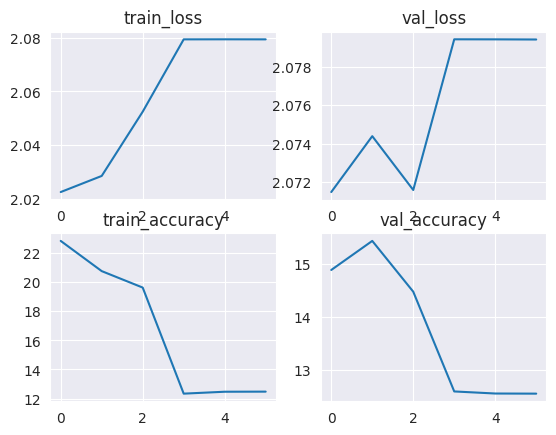

In [8]:
cnnsa_model = CNNSA(sample_rate=22050, n_class=NUM_CLASSES, f_max=11025, n_mels=48).to(DEVICE)
train_progress, val_progress = executor(DEVICE, cnnsa_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=15, learning_rate=0.001, weight_decay=0.1, evaluate_per_iteration=10, early_stop_after=(5,  0.001))

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       Blues       0.00      0.00      0.00       249
   Classical       0.13      1.00      0.23       254
  Electronic       0.00      0.00      0.00       250
        Folk       0.00      0.00      0.00       249
     Hip-Hop       0.00      0.00      0.00       251
        Jazz       0.00      0.00      0.00       251
         Pop       0.00      0.00      0.00       233
        Rock       0.00      0.00      0.00       247

    accuracy                           0.13      1984
   macro avg       0.02      0.12      0.03      1984
weighted avg       0.02      0.13      0.03      1984



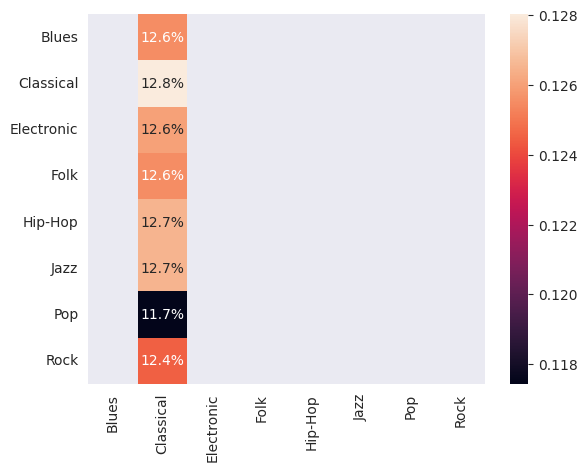

In [9]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, cnnsa_model, test_data_loader, criterion=nn.CrossEntropyLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred, idx_to_label, transform_idx_to_label)

  7%|▋         | 1/15 [28:11<6:34:39, 1691.36s/it]

2.022881815351289 2.0682089554000007


 13%|█▎        | 2/15 [56:30<6:07:29, 1696.10s/it]

1.995180236882177 2.0323977291858695


 20%|██        | 3/15 [1:24:34<5:38:05, 1690.46s/it]

1.999033733071952 2.0313576959794566


 27%|██▋       | 4/15 [1:52:34<5:09:11, 1686.45s/it]

2.0098906311495552 2.0409953283824125


 33%|███▎      | 5/15 [2:20:44<4:41:15, 1687.57s/it]

2.023226554640408 2.04952436108743


 40%|████      | 6/15 [2:48:44<4:12:44, 1684.94s/it]

2.0331938677820665 2.056821582504132


 47%|████▋     | 7/15 [3:16:43<3:44:24, 1683.11s/it]

2.046438592055748 2.06113833491154


 47%|████▋     | 7/15 [3:44:40<4:16:46, 1925.85s/it]

2.0575986549772067 2.067360742300886
Early stop!


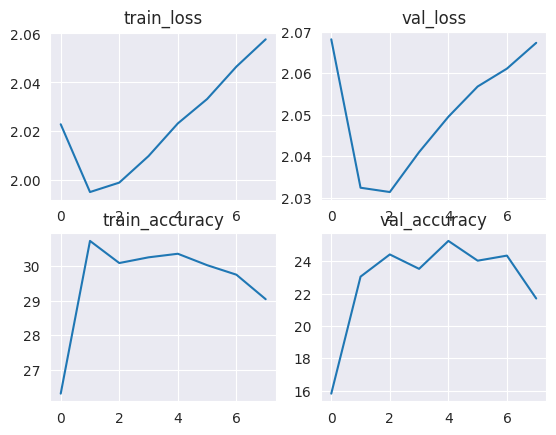

In [9]:
from models.genre_classification.sota_models.HarmonicCNN import HarmonicCNN

harmonic_cnn_model = HarmonicCNN(sample_rate=22050, n_class=NUM_CLASSES, f_max=11025, n_channels=16).to(DEVICE)
train_progress, val_progress = executor(DEVICE, harmonic_cnn_model, train_dataloader = train_data_loader, val_dataloader=val_data_loader, epochs=15, learning_rate=0.001, weight_decay=0.1, evaluate_per_iteration=10, early_stop_after=(5,  0.001), print_metrics=True)

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

In [10]:
import torch
import gc
torch.cuda.empty_cache() # PyTorch thing
gc.collect()

17225